In [1]:
import utils
import keras
import model01
import datasets
import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline

Using TensorFlow backend.


In [2]:
# FILENAME = './output/MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5-200-0.6926.hdf5'
#FILENAME = './output/MLPModel01_20170310_0845_LA1_F99_C2_L100_100_100_DO0.5-200-0.6890.hdf5'
FILENAME = './output/MLPModel01_20170412_0617_LA1_F99_C2_L100_100_100_DO0.5-065-0.6920.hdf5'

In [4]:
#model = model01.MLPModel01.load(FILENAME)
# infers model description file from this filename
# loads model training history + weights from this specific file

In [5]:
model = keras.models.load_model(FILENAME)

In [6]:
#pc = model01.ProgressCallback.load('MLPModel01_20170306_1222_LA1_F243_C2_L100_100_100_DO0.5')
#pc = model01.ProgressCallback.load('MLPModel01_20170310_0845_LA1_F99_C2_L100_100_100_DO0.5')
pc = model01.ProgressCallback.load('MLPModel01_20170412_0617_LA1_F99_C2_L100_100_100_DO0.5')


loading from file: ./output/MLPModel01_20170412_0617_LA1_F99_C2_L100_100_100_DO0.5.npz


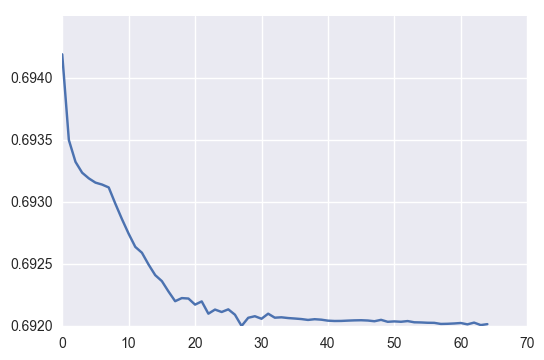

In [7]:
plt.plot(pc.validation_losses)

In [10]:
# load test dataset
lookahead=1
dataset = 'DS3'
window=25
sym='EURUSD'
year=2015
X_test, Y_test, prices_test = datasets.load(datasets.filename(dataset, lookahead, window, sym, year))

test: f1-score: 0.512, mean future return: 0.025 bps


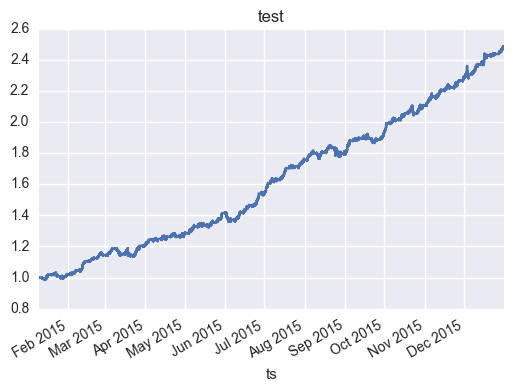

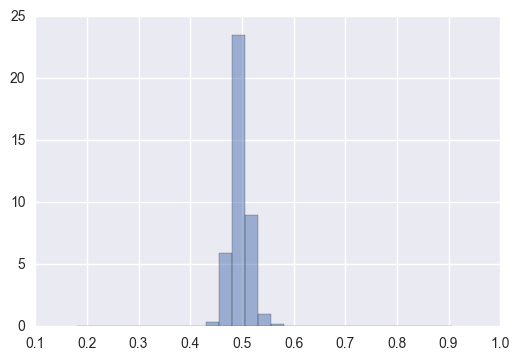

[[112511  68199]
 [107475  75543]]


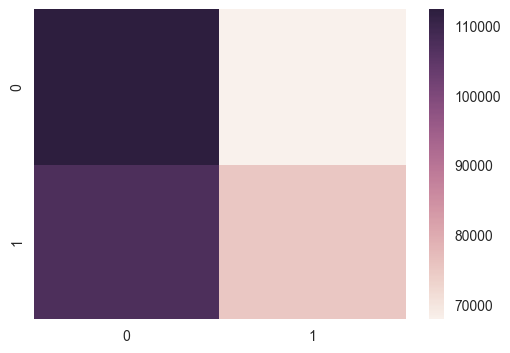

In [11]:
Y_test_pred = model.predict(X_test.as_matrix(), batch_size=1024)
metrics.performance_report("test",  prices_test,  lookahead, Y_test, Y_test_pred, cum_return_plot=True, histogram=True, heatmap=True)

-----------------------------------------


In [9]:
!! Idea: assess performance of 1 minute prediction over next n periods, e.g. by average signal, ewma signal.
    Versus predicting on n periods ahead directly.
    
    Increase N to point of being potentially tradeable.
    
    

IndentationError: unexpected indent (<ipython-input-9-a53d670d1814>, line 2)

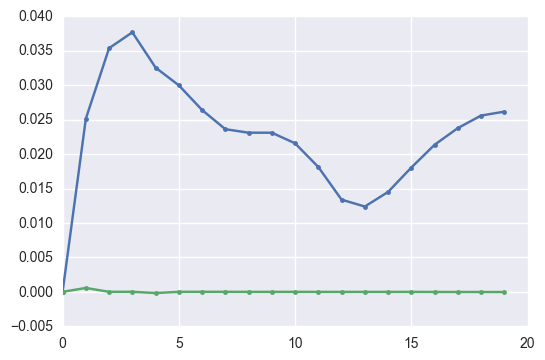

In [12]:
i_s = []
frsma = []
frewma = []
for i in range(20):
    i_s.append(i)
    fut_ret_sma = metrics.aggregated_predicted_future_return(
        prices=prices_test, prediction=Y_test_pred, agg_period=i, mode='sma').mean() *1e4
    frsma.append(fut_ret_sma)
    
    fut_ret_ewma = metrics.aggregated_predicted_future_return(
        prices=prices_test, prediction=Y_test_pred, agg_period=i, mode='ewm').mean() *1e4
    frewma.append(fut_ret_ewma)

plt.plot(i_s, frsma,'.-')
plt.plot(i_s, frewma,'.-')
    

??? why are perf charts below different to fut return charts from performance report.????

In [25]:
fut_return_test = utils.future_return(prices_test, 1)

In [26]:
def perf(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    cats = utils.prediction_to_category2(preds)
    # turn true/false into +1/-1
    signs = cats*2 -1 
    
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [27]:
def perf2(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    # turn true/false into +1/-1
    signs = preds - 0.5
    
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [28]:
def perf3(Y, fut_ret):
    preds = Y[:,0]
    rets = fut_ret.fillna(0).values
    assert preds.shape == rets.shape
    
    # turn true/false into +1/-1
    signs = (preds - 0.5)
    signs = np.tanh(signs/2)
    applied_rets = signs*rets / signs.std()
    ser =  pd.Series(applied_rets, index=fut_ret.index)   
    print ser.mean()/ser.std()
    return ser

In [29]:
print perf(Y_test_pred, fut_return_test).sum()
print perf2(Y_test_pred, fut_return_test).sum()
print perf3(Y_test_pred, fut_return_test).sum()

0.0122660329019
0.952012723526
0.00777558748553
1.68342089862
0.00778569398168
1.68030064559


0.0122660329019
0.00777558748553
0.00778569398168


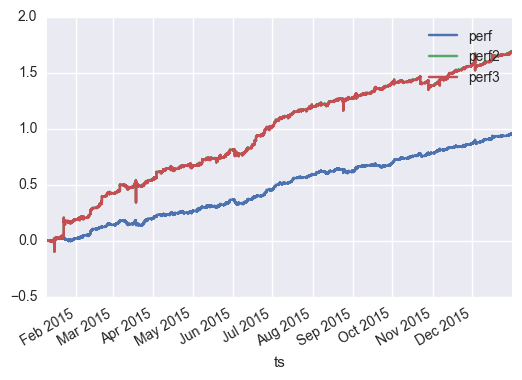

In [30]:
perf(Y_test_pred, fut_return_test).cumsum().plot(label='perf')
perf2(Y_test_pred, fut_return_test).cumsum().plot(label='perf2')
perf3(Y_test_pred, fut_return_test).cumsum().plot(label='perf3')
plt.legend()

-----------------------------------

## Control

In [18]:
X_control, Y_control, prices_control = datasets.prepare_dataset3(df=datasets.random_ohlc(100000),lookahead=1, n_periods=25)

In [19]:
X_test.describe()

,open-0,high-0,low-0,open-1,high-1,low-1,close-1,open-2,high-2,low-2,...,low-328,close-328,open-365,high-365,low-365,close-365,open-404,high-404,low-404,close-404
count,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,...,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000,363728.000000
mean,-0.000123,-0.006427,0.006614,-0.000124,-0.006428,0.006613,-0.000155,-0.000121,-0.006427,0.006615,...,0.006012,-0.002871,-0.000283,-0.006048,0.006105,-0.003257,-0.000279,-0.006123,0.006190,-0.003820
std,0.991612,0.990383,0.987160,0.991613,0.990384,0.987161,0.987123,0.991613,0.990384,0.987161,...,0.989128,1.009940,0.992712,0.991236,0.988915,1.011574,0.992617,0.991172,0.988781,1.013138
min,-36.860385,-0.887879,-52.469959,-36.860385,-0.887879,-52.469959,-40.721867,-36.860385,-0.887879,-52.469959,...,-52.469959,-11.655039,-36.860385,-0.887879,-52.469959,-11.126010,-36.860385,-0.887879,-52.469959,-10.685419
25%,-0.406567,-0.633937,-0.269361,-0.406575,-0.633937,-0.269366,-0.402563,-0.406575,-0.633937,-0.269366,...,-0.269753,-0.545159,-0.406790,-0.633869,-0.269699,-0.552092,-0.406744,-0.633881,-0.269626,-0.557904
50%,-0.003780,-0.302808,0.294591,-0.003780,-0.302808,0.294591,-0.001427,-0.003779,-0.302808,0.294592,...,0.294291,-0.017513,-0.003760,-0.302666,0.294322,-0.019014,-0.003760,-0.302723,0.294363,-0.013733
75%,0.407217,0.275544,0.626799,0.407217,0.275544,0.626799,0.401355,0.407225,0.275566,0.626799,...,0.626578,0.520430,0.407299,0.276021,0.626590,0.528601,0.407285,0.275907,0.626583,0.536106
max,42.406929,48.811838,0.867707,42.406929,48.811838,0.867707,50.983090,42.406929,48.811838,0.867707,...,0.867707,6.731499,42.406929,48.811838,0.867707,6.740846,42.406929,48.811838,0.867707,6.481164


In [20]:
X_control.describe()

,open-0,high-0,low-0,open-1,high-1,low-1,close-1,open-2,high-2,low-2,...,low-328,close-328,open-365,high-365,low-365,close-365,open-404,high-404,low-404,close-404
count,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,...,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000,91518.000000
mean,0.001040,0.001030,0.000719,0.001065,0.001058,0.000755,0.000648,0.001076,0.001067,0.000774,...,0.000690,0.009451,0.001115,0.001279,0.000765,0.010447,0.001142,0.001255,0.000847,0.010790
std,1.000033,1.000594,0.999033,1.000012,1.000602,0.999006,0.999736,1.000007,1.000604,0.999008,...,0.999255,1.005014,1.000224,1.000774,0.999087,1.006407,1.000158,1.000717,0.999054,1.008881
min,-4.230146,-0.994892,-6.718379,-4.230146,-0.994892,-6.718379,-4.612441,-4.230146,-0.994892,-6.718379,...,-6.718379,-3.623014,-4.230146,-0.994892,-6.718379,-3.580534,-4.230146,-0.994892,-6.718379,-3.787949
25%,-0.677722,-0.947445,-0.582386,-0.677665,-0.947443,-0.582374,-0.679971,-0.677645,-0.947443,-0.582345,...,-0.582673,-0.678244,-0.677722,-0.947427,-0.582573,-0.684176,-0.677645,-0.947415,-0.582407,-0.695921
50%,-0.002742,-0.253369,0.254656,-0.002726,-0.253365,0.254702,-0.002174,-0.002716,-0.253357,0.254739,...,0.254740,0.004953,-0.002726,-0.253311,0.254740,-0.006300,-0.002708,-0.253365,0.254791,-0.005984
75%,0.677784,0.579400,0.949384,0.677784,0.579448,0.949387,0.674660,0.677784,0.579521,0.949389,...,0.949527,0.681655,0.678242,0.579803,0.949517,0.699318,0.678173,0.579758,0.949503,0.696503
max,5.401377,7.995290,0.997120,5.401377,7.995290,0.997120,4.764920,5.401377,7.995290,0.997120,...,0.997120,3.264143,5.401377,7.995290,0.997120,3.291089,5.401377,7.995290,0.997120,3.384595


In [21]:
Y_control_pred = model.predict(X_control.as_matrix(), batch_size=1024)
Y_control_pred_class = utils.prediction_to_category2(Y_control_pred)
metrics.performance_report("control",  prices_control,  lookahead, Y_control, Y_control_pred_class)

control: f1-score: 0.498, mean future return: -0.001 bps


In [22]:
(fut_return_control.ix[~Y_control_pred_class[:,0]]+1).mean() - fut_return_control.mean() - 1

NameError: name 'fut_return_control' is not defined